In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 500
M = 20

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,1+num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [5]:
# def get_df(idx_resample,perm):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,q,elbos,resampled_subj_list = pickle.load(f)
    
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df,model

In [6]:
from scipy.stats import linregress

def get_distance_slopes(df, model):

    attractor_y = np.zeros((K, N))
    attractor_x = np.zeros((K, D))

    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        C = model.emissions.Cs[0]
        d = model.emissions.ds[0]
        x_bar = np.linalg.inv(np.eye(A.shape[0])-A)@b
        attractor_x[idx_state,:] = x_bar
        y_bar = np.expand_dims(C @ x_bar + d,axis=0)
        attractor_y[idx_state,:] = y_bar

    slope_state = {}
    for idx_state in range(K):
        slope_vals = []
        for idx_row in range(df.shape[0]):
            z = df.loc[idx_row]['discrete_states']
            x = df.loc[idx_row]['timeseries']

            idx_begin = list(np.where((z[:-1]!=idx_state)&(z[1:]==idx_state))[0]+1)
            idx_end = list(np.where((z[:-1]==idx_state)&(z[1:]!=idx_state))[0])
            if z[0] == idx_state: idx_begin = [0] + idx_begin
            if z[-1] == idx_state: idx_end = idx_end + [len(z)-1]
            for st,en in zip(idx_begin,idx_end):
                if en-st<4: continue
                d_win = np.linalg.norm(x[st:en+1]-attractor_y[idx_state:idx_state+1,:],axis=1)
                t = np.arange(len(d_win))
                
                line = linregress(x=t,y=d_win,alternative='less')
                slope_vals.append(line.slope)
        slope_state[idx_state] = slope_vals

    return slope_state

In [7]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs.pkl','rb') as f:
    state_masks = pickle.load(f)

In [8]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [9]:
all_slopes = {i:[] for i in range(K)}
for idx_resample in tqdm(range(1,num_resamples+1)):
    state_mask = state_masks[idx_resample]
    slope_state = get_distance_slopes(all_dfs[idx_resample], all_models[idx_resample])
    for idx_state in range(K):
        if state_mask[idx_state] == 0:
            # all_slopes[idx_state] += slope_state[idx_state]
            all_slopes[idx_state].append(np.mean(slope_state[idx_state]))


 60%|██████    | 300/500 [11:55<07:56,  2.38s/it]


KeyError: 301

State 1 TtestResult(statistic=-26.283271701396963, pvalue=3.818326922322426e-66, df=194)
State 2 TtestResult(statistic=-18.278503378578417, pvalue=7.653960194347945e-48, df=243)
State 3 TtestResult(statistic=-11.299405759604198, pvalue=7.626491715853968e-24, df=215)
State 4 TtestResult(statistic=-15.758952909858506, pvalue=1.3710370606569804e-37, df=207)
State 5 TtestResult(statistic=-16.016019883463677, pvalue=1.0180865707357465e-38, df=213)


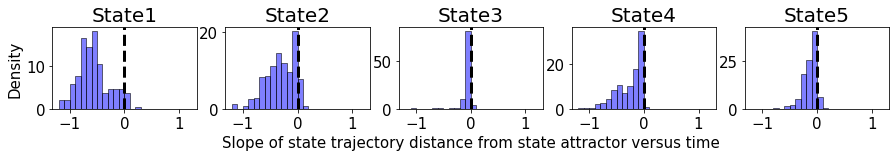

In [ ]:
from scipy.stats import ttest_1samp
state_names = [f'State{k+1}' for k in range(K)]
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(15,1.5),sharex=False,sharey=False)
for i,idx_state in enumerate([0,1,2,3,4]):
    ax = axs[i]
    vals = all_slopes[idx_state]
    sns.histplot(vals,binwidth=0.1,binrange=[-1.2,1.2],ax=ax,kde=False,stat='percent',color='blue',alpha=0.5)
    ax.axvline(x=0,color='k',linewidth=3,linestyle='--')
    ax.set_title(f'{state_names[idx_state]}',fontsize=20)
    if idx_state==0:
        ax.set_ylabel('Density',fontsize=15)
    else:
        ax.set_ylabel('')
    if i==2:
        ax.set_xlabel("Slope of state trajectory distance from state attractor versus time",fontsize=15)
    ax.tick_params(axis='both',labelsize=15)
    print("State",idx_state+1,ttest_1samp(vals,0,alternative='less'))
# fig.tight_layout()
fig.savefig(f'figures/fig_fixed_point_convergence_K{K}.jpg',dpi=600,bbox_inches='tight')
